In [1]:
import os
import math

import torch
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.notebook import tqdm, trange

from taskpriors import sampler

In [2]:
# List available kernel files
KERNEL_DIR = Path("./kernels_out")
kernel_files = list(KERNEL_DIR.glob("K_*.pt"))

if not kernel_files:
    print("No kernel files found in 'kernels_out' directory!")
    print("Please run generate_timm_kernels.ipynb first.")
else:
    print(f"Found {len(kernel_files)} kernel files:")
    for i, f in enumerate(kernel_files):
        model_name = f.stem.split('_', 1)[1].rsplit('_', 1)[0]
        n_images = int(f.stem.split('_')[-1])
        print(f"[{i}] {model_name} ({n_images} images)")

Found 33 kernel files:
[0] convnextv2_base (8192 images)
[1] wide_resnet101_2 (8192 images)
[2] deit_small_patch16_224 (8192 images)
[3] regnety_032 (8192 images)
[4] deit_tiny_patch16_224 (8192 images)
[5] mixer_b16_224 (8192 images)
[6] resnet50 (8192 images)
[7] densenet121 (8192 images)
[8] efficientnet_b5 (8192 images)
[9] swin_base_patch4_window7_224 (8192 images)
[10] mobilenetv3_large_100 (8192 images)
[11] pvt_v2_b2 (8192 images)
[12] wide_resnet50_2 (8192 images)
[13] gcvit_base (8192 images)
[14] ese_vovnet39b (8192 images)
[15] convnext_base (8192 images)
[16] dm_nfnet_f0 (8192 images)
[17] efficientnet_b0 (8192 images)
[18] deit_base_patch16_224 (8192 images)
[19] resnext50_32x4d (8192 images)
[20] beit_base_patch16_224 (8192 images)
[21] resnet101 (8192 images)
[22] resnet152 (8192 images)
[23] ghostnet_100 (8192 images)
[24] densenet201 (8192 images)
[25] resnet34 (8192 images)
[26] swin_tiny_patch4_window7_224 (8192 images)
[27] convnext_small (8192 images)
[28] vit_bas

In [3]:
selected_kernel_idx = 0

selected_kernel = kernel_files[selected_kernel_idx].stem

In [10]:
# Average all the kernels K from the kernel files
all_K = []
for kernel_file in kernel_files:
    data = torch.load(kernel_file)
    K_matrix = data['K'].numpy()
    all_K.append(K_matrix)

# Ensure all kernels have the same shape
shapes = [k.shape for k in all_K]
if not all(s == shapes[0] for s in shapes):
    raise ValueError(f"Not all kernels have the same shape: {shapes}")

K_avg = np.mean(np.stack(all_K, axis=0), axis=0)
print(f"Averaged kernel shape: {K_avg.shape}")


Averaged kernel shape: (8192, 8192)


In [23]:
selected_kernel = 'avg'

In [4]:
# Load the selected kernel
selected_kernel_file = KERNEL_DIR / f"{selected_kernel}.pt"
kernel_data = torch.load(selected_kernel_file)

K = kernel_data['K'].numpy()
Z = kernel_data['Z'].numpy()
indices = kernel_data['indices']
feat_dim = kernel_data['dim']

print(f"Loaded kernel: {selected_kernel}")
print(f"Kernel shape: {K.shape}")
print(f"Original feature dimension: {feat_dim}")

Loaded kernel: K_convnextv2_base_8192
Kernel shape: (8192, 8192)
Original feature dimension: 1024


In [5]:
# Apply t-SNE for visualization
print("Computing t-SNE embedding...")
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_2d = tsne.fit_transform(Z)
print("t-SNE completed.")

Computing t-SNE embedding...
t-SNE completed.


  0%|          | 0/9 [00:00<?, ?it/s]

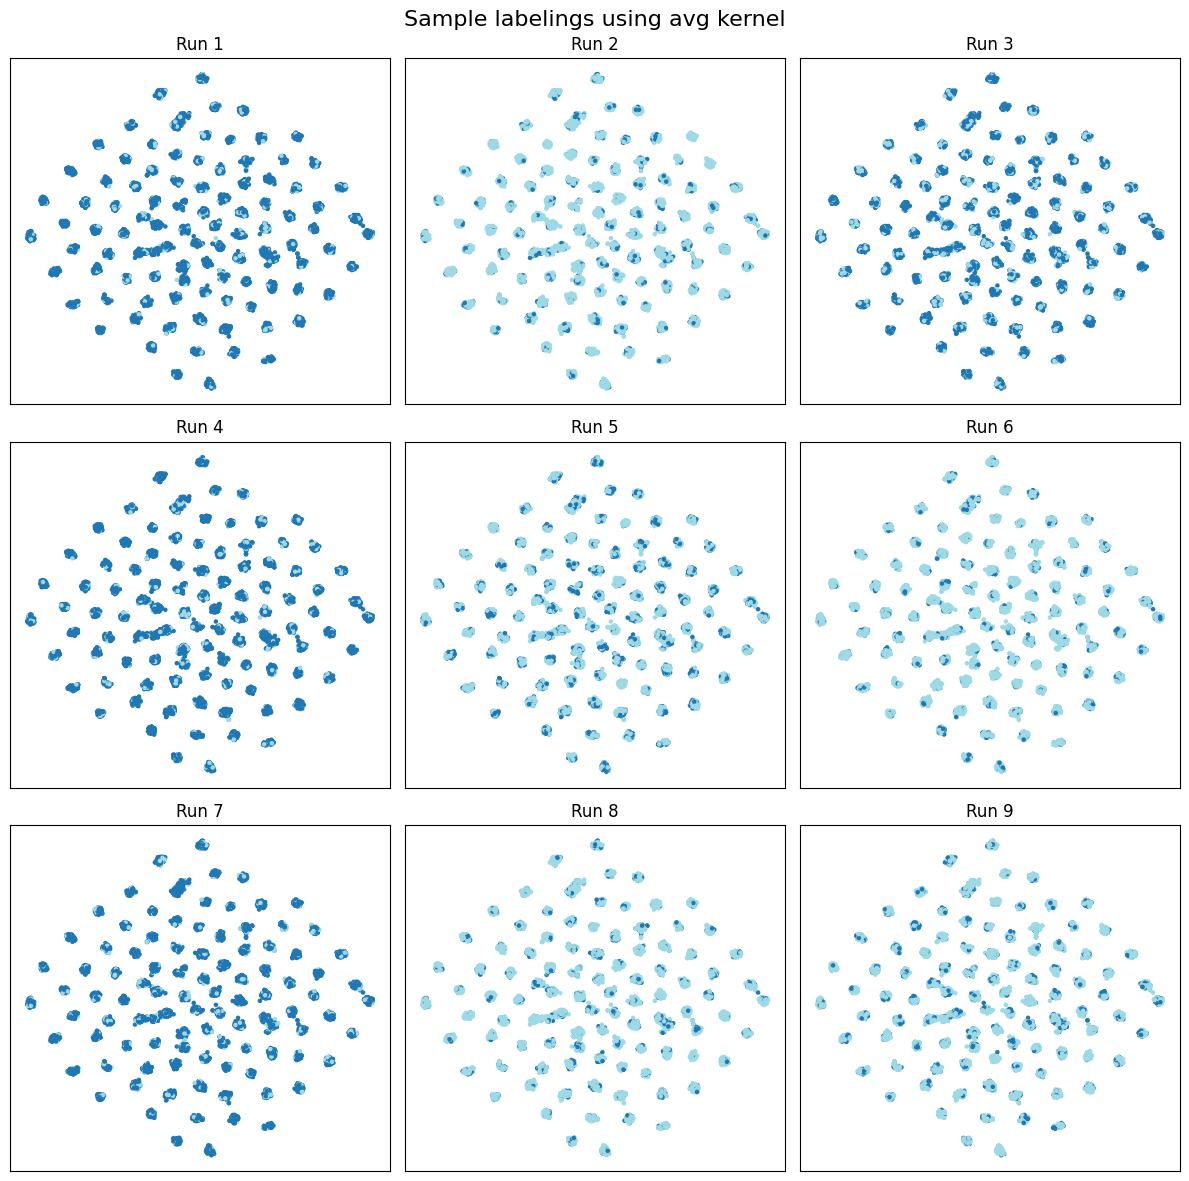

In [24]:
# Generate and visualize a sample of labelings
n_samples = 9
cols = 3
rows = math.ceil(n_samples / cols)

n_classes = 2 # Number of classes
temp = 100000 # Sampling temperature

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), tight_layout=True)
axes = axes.flatten()
sample_labels_list = []

for i in trange(n_samples):
    # Generate labels
    labels = sampler.sample_labels_from_kernel(K_avg, num_classes=n_classes, temperature=temp, seed=i)
    sample_labels_list.append(labels)
    
    # Plot
    ax = axes[i]
    scatter = ax.scatter(emb_2d[:, 0], emb_2d[:, 1],
               c=labels, cmap="tab20", s=5, alpha=1)
    ax.set_title(f"Run {i+1}")
    ax.set_xticks([])
    ax.set_yticks([])

# Hide any extra axes
for ax in axes[n_samples:]:
    ax.axis("off")

plt.suptitle(f"Sample labelings using {selected_kernel} kernel", fontsize=16)
plt.show()

In [25]:
# Generate a larger set of labelings to save and evaluate

n_runs = 512  # Number of different labelings to generate
labels_list = []

for i in trange(n_runs):
    labels_run = sampler.sample_labels_from_kernel(K, num_classes=n_classes, temperature=temp, seed=i)
    labels_list.append(labels_run)

# Convert to numpy array and save
labels_array = np.array(labels_list)
print(f"Generated labels shape: {labels_array.shape}")

# Ensure output directory exists
output_dir = "labels_out"
os.makedirs(output_dir, exist_ok=True)

# Extract model name for the filename
output_file = os.path.join(output_dir, f"labels_mini_imagenet_{selected_kernel}.npy")

np.save(output_file, labels_array)
print(f"Saved labels to {output_file}")

  0%|          | 0/512 [00:00<?, ?it/s]

Generated labels shape: (512, 8192)
Saved labels to labels_out/labels_mini_imagenet_avg.npy
